## Potential Talents - Part 5_training

----

## Potential Talents — Part 5t (training): Instruction FT with LoRA for Job-Title Similarity

### Objective
Fine-tune **meta-llama/Llama-3.2-3B-Instruct** to output a **single 0–100 score** for (query, job-title) pairs.  
Training uses the JSONL splits produced in Part 5 and supervises **only the numeric target** (+EOS) while **masking prompt tokens**.

### Constraints
- **GTX 1080 Ti (11 GB)**, FP16, short sequences (≤256 tokens).
- Safe memory profile: `device_map="auto"` + offload to **E:\\hf_offload**.
- Lightweight LoRA adapter training (no full-model FT).

### Method (this notebook)
1) **Load splits** from `ft_data/` (train/val[/test]).  
2) **Tokenizer** with chat template. Set PAD=EOS when missing.  
3) **Build inputs** concatenate prompt+target. Labels are `-100` over prompt and ids over target integer (supervised).  
4) **Model setup** load base FP16, enable grad checkpointing, attach **LoRA** (`r=16`, common LLaMA proj modules).  
5) **Training** → `bsz=1`, `grad_acc=16`, cosine LR, warmup, eval every 400 steps.  
6) **Evaluate & save** print eval loss; save **LoRA adapter** and **tokenizer** to `runs/llama_pairwise_lora/`.

### Outputs
- LoRA adapter: `runs/llama_pairwise_lora/adapter/`  
- Tokenizer: `runs/llama_pairwise_lora/tokenizer/`  
- Ready to load back in Part 5 for inference, ranking, and analysis.



----


### 0. Imports, configuration and folders

In [1]:
import os, math, torch, json
import numpy as np
import pandas as pd
from datasets import load_dataset, DatasetDict
from transformers import (AutoTokenizer, AutoModelForCausalLM, TrainingArguments,
                          DataCollatorForLanguageModeling, Trainer, BitsAndBytesConfig)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

# ad-hoc toolkit
import tools_llm_ift


In [2]:
import torch
print(torch.__version__)
print("built with CUDA:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))


2.6.0+cu124
built with CUDA: 12.4
cuda available: True
gpu: NVIDIA GeForce GTX 1080 Ti


In [3]:
tools_llm_ift.free_GPU_memory()

Measure memory usage before and after freeing it

Before:
allocated: 0.0 MiB | reserved: 0.0 MiB | total: 11,264 MiB

After:
allocated: 0.0 MiB | reserved: 0.0 MiB | total: 11,264 MiB


In [ ]:
MODEL_ID = "meta-llama/Llama-3.2-3B-Instruct"
DATA_DIR = "ft_data"  # where jsonls files are placed
TRAIN_PATH = os.path.join(DATA_DIR, "llama_pairwise_train.jsonl")
VAL_PATH   = os.path.join(DATA_DIR, "llama_pairwise_val.jsonl")
TEST_PATH  = os.path.join(DATA_DIR, "llama_pairwise_test.jsonl")

assert os.path.exists(TRAIN_PATH) and os.path.exists(VAL_PATH), "JSONL files not found."


In [ ]:
# Load data
dset = DatasetDict({
    "train": load_dataset("json", data_files=TRAIN_PATH, split="train"),
    "val":   load_dataset("json", data_files=VAL_PATH,   split="train"),
})
if os.path.exists(TEST_PATH):
    dset["test"] = load_dataset("json", data_files=TEST_PATH, split="train")

In [ ]:
# Tokenizer
tok = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True, token=os.getenv("HF_TOKEN"))
if tok.pad_token_id is None:
    tok.pad_token = tok.eos_token  # set <eos> token as padding token


In [ ]:
# Format → tokenize → mask prompt tokens
# We supervise only the assistant response (the integer). We build a chat prompt using the template,
# then append the target integer + eos. Labels are -100 over prompt tokens and equal to ids over the target.

def build_texts(example):
    messages = example["messages"]
    # chat template up to the assistant turn (we add generation prompt)
    prompt_text = tok.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    target_text = str(example["response"]).strip() + tok.eos_token
    return {"prompt_text": prompt_text, "target_text": target_text}

def tokenize_and_mask(example):
    prompt_ids = tok(example["prompt_text"], add_special_tokens=False)["input_ids"]
    target_ids = tok(example["target_text"], add_special_tokens=False)["input_ids"]
    input_ids = prompt_ids + target_ids
    labels = [-100]*len(prompt_ids) + target_ids  # mask prompt. Supervise only the integer (+ eos)
    return {"input_ids": input_ids, "labels": labels}

dset = dset.map(build_texts, remove_columns=dset["train"].column_names)
dset = dset.map(tokenize_and_mask, remove_columns=["prompt_text","target_text"])

# Optional: truncate long examples (should be tiny, titles are short)
MAX_LEN = 256
def clip(example):
    example["input_ids"] = example["input_ids"][:MAX_LEN]
    example["labels"]    = example["labels"][:MAX_LEN]
    return example
dset = dset.map(clip)



#### Why `labels = [-100]*len(prompt_ids) + target_ids`

During fine-tuning, the model input is built by **concatenating the prompt and the target**: input_ids = prompt_ids + target_ids

However, we only want the model to **learn to predict the target (the assistant’s answer)**, not to reproduce the prompt text itself.

In Hugging Face’s `Trainer`, the loss is computed using `CrossEntropyLoss`, which ignores positions where the label value is `-100`.  
This is the default **ignore index** in PyTorch (`ignore_index=-100`).

#### Example of how masking works in practice

Let’s see what happens step by step. After tokenization, we have two sequences:

- **Prompt tokens**: all text up to the assistant’s turn, the system and user messages.  
  Example (schematically):  
`[1, 910, 299, ..., 128009] # prompt_ids`

- **Target tokens**: the assistant’s numeric answer followed by the end-of-sequence token.  
`[4571, 128001] # target_ids → "38" + </s>`

- These are concatenated to form the full model input:
  
    `input_ids = [1, 910, 299, ..., 128009, 4571, 128001]`

- For the labels, all prompt tokens are replaced with **`-100`**, while the target tokens keep their real IDs:
  
    `labels = [-100, -100, -100, ..., -100, 4571, 128001]`

During training, the model computes a prediction for every position in `input_ids`, but the **loss function ignores** positions with `-100`.  

As a result, the model learns only from the last tokens, in this case, to output `"38"` followed by `</s>`, given the full conversational context as input.



In [ ]:
# Plain FP16 base model. No bitsandbytes, no QLoRA for the moment. I will just use LoRA, which should fit in my GPU (+CPU & paging if needed)

OFFLOAD_DIR = r"E:\hf_offload"  # E: is my w/r faster drive
os.makedirs(OFFLOAD_DIR, exist_ok=True)

base = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    dtype=torch.float16,       
    device_map="auto",
    low_cpu_mem_usage=True,          # stream shards to target device(s)
    offload_folder=OFFLOAD_DIR,      # spill to disk if needed
    max_memory={                     
        0: "10GiB",                  
        "cpu": "16GiB",              
        # "disk": "200GiB",          # optional if supported
    },
    token=os.getenv("HF_TOKEN"),
)

base.gradient_checkpointing_enable()
base.config.use_cache = False

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
lora_cfg = LoraConfig(
    r=16, 
    lora_alpha=32, 
    lora_dropout=0.05, 
    bias="none",
    target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
    task_type="CAUSAL_LM",
)
model = get_peft_model(base, lora_cfg)
model.print_trainable_parameters()

trainable params: 24,313,856 || all params: 3,237,063,680 || trainable%: 0.7511


This block attaches a LoRA adapter to the frozen Llama base model so that only a tiny fraction of its parameters are trainable, in this case, about 24 million out of 3.2 billion (≈ 0.75%).

The LoraConfig defines how and where these lightweight adapters are injected:
- **r=16** sets the rank of the low-rank update matrices. 
  
  W' = W + ∆W

  ∆W = AxB

  A is a matrix of shape (out_features, **r**), B is a matrix of shape (**r**, in_features)

- **lora_alpha=32** controls their scaling (like a gain factor).

  W' = W + (α/r)∆W

  **α** controls how much weight the LoRA update has relative to the frozen base weights.

- **lora_dropout=0.05** adds mild regularization.
- **bias="none"** keeps the original biases fixed.
- **target_modules** specifies which layers LoRA modifies, key attention and MLP projections (q_proj, k_proj, v_proj, o_proj, gate_proj, up_proj, down_proj), the components that most influence model reasoning and representation.
- 
  Where `q_proj`, `k_proj`, and `v_proj` are the matrices that generate the queries, keys, and values from the attention mechanism. 
  `o_proj` is the output projection that maps the attended results back into the hidden dimension.

  `gate_proj`, `up_proj`, `down_proj` are related with the following part, which goes through a feed-forward sublayer:
   h = activation(X.W_up) @ X.W_gate
   Y = h.W_down
   
This “up → gate → down” structure allows the model to mix nonlinear transformations and learn richer representations efficiently.

- **task_type="CAUSAL_LM"** ensures proper setup for autoregressive text generation.

Finally, `get_peft_model(base, lora_cfg)` wraps the base model with these adapters, freezing all original weights, `while model.print_trainable_parameters()` confirms that only **0.75%** of parameters will be fine-tuned, keeping GPU usage low and training efficient without sacrificing learning capacity.

In [ ]:
# Data collator (no MLM)
collator = DataCollatorForLanguageModeling(tok, mlm=False)

This **collator** batches + pads prepare the examples for autoregressive training while respecting the precomputed labels.

In [ ]:
# Training args (11 GB 1080 Ti)
bsz = 1                # conservative configuration. Change to '2' to increase training speed 
grad_acc = 16          # conservative configuration. Change to 8 to increase training speed
# bsz × grad_acc = 16 sequences per update, without blowing VRAM
lr = 2e-4
epochs = 2

args = TrainingArguments(
    output_dir="runs/llama_pairwise_lora",
    per_device_train_batch_size=bsz,
    per_device_eval_batch_size=bsz,
    gradient_accumulation_steps=grad_acc,
    fp16=True, bf16=False,                  # Pascal GPU -> fp16 only

    # Logging & eval cadence
    logging_strategy="steps",
    logging_steps=50,                       # denser logs
    eval_strategy="steps",
    eval_steps=400,                         
    save_steps=800,
    save_total_limit=2,

    # Model selection
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,

    # Optimization
    learning_rate=lr,
    num_train_epochs=epochs,
    max_grad_norm=1.0,
    weight_decay=0.0,
    lr_scheduler_type="cosine",
    warmup_ratio=0.03,

    # Reporting
    report_to=["tensorboard"],              # <— enable TB
    logging_dir="runs/tb/llama_pairwise_lora",
    run_name="llama_pairwise_lora",

    # Dataloader/system
    dataloader_pin_memory=True,
    dataloader_num_workers=0,               # Windows: safer to keep 0. Try '2' to increase training speed.

    # Trainer/model plumbing
    remove_unused_columns=False,            # safe for causal LM w/ custom inputs
)



#### **Forward pass → logits**

The model produces:
- logits with shape **[batch, seq_len, vocab]** for every position in input_ids.
  
These logits are conditioned on the entire prefix up to that position (causal mask), so the numeric answer is predicted given the full prompt.

#### **Shifted LM objective**
```
shift_logits = logits[..., :-1, :]   # drop last time step
shift_labels = labels[..., 1:]       # drop first label
loss = CrossEntropyLoss(ignore_index=-100)(shift_logits.reshape(-1, V),
                                           shift_labels.reshape(-1))
```

#### **Visualize the dynamic**, simple numerical example:
**Suppose:**
* input_ids: [p1, p2,  t1,  t2, eos]
* labels:    [-100,-100, t1,  t2, eos]

**After shifting:**
* shift_logits at positions:  [p1,   p2,   t1,   t2]
* shift_labels:              [-100,  t1,   t2,   eos]

Them, **Loss** terms used:

- ignore -100 (at p1)
- CE(logits_at_p2, t1)
- CE(logits_at_t1, t2)
- CE(logits_at_t2, eos)

Average those three -> example loss.


In [18]:
# Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dset["train"],
    eval_dataset=dset["val"],
    data_collator=collator,
    processing_class=tok,
)


The model is already on multiple devices. Skipping the move to device specified in `args`.


The “already on multiple devices” line is harmless, it comes from using device_map="auto".

In [19]:
print("Train examples:", len(dset["train"]), "| Val examples:", len(dset["val"]))
train_out = trainer.train()
print(train_out)

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'pad_token_id': 128009}.


Train examples: 10000 | Val examples: 1250


Step,Training Loss,Validation Loss
400,0.179000,0.227253
800,0.113600,0.189347
1200,0.101300,0.186002


TrainOutput(global_step=1250, training_loss=0.21000949096679689, metrics={'train_runtime': 12656.7999, 'train_samples_per_second': 1.58, 'train_steps_per_second': 0.099, 'total_flos': 4.83853429282775e+16, 'train_loss': 0.21000949096679689, 'epoch': 2.0})


In [20]:
# Eval
eval_metrics = trainer.evaluate()
print("Eval:", eval_metrics)

Eval: {'eval_loss': 0.18934723734855652, 'eval_runtime': 239.1882, 'eval_samples_per_second': 5.226, 'eval_steps_per_second': 5.226, 'epoch': 2.0}


In [21]:
# Collect Trainer logs
diag_dir = os.path.join(args.output_dir, "diagnostics")
os.makedirs(diag_dir, exist_ok=True)

log_df = pd.DataFrame(trainer.state.log_history)
log_csv = os.path.join(diag_dir, "trainer_log_history.csv")
log_df.to_csv(log_csv, index=False)

In [24]:
import matplotlib.pyplot as plt

In [25]:
# Training loss over steps
fig1 = plt.figure(figsize=(7,4))
tmp = log_df[log_df["loss"].notna()]
plt.plot(tmp["step"], tmp["loss"])
plt.xlabel("Step")
plt.ylabel("Training loss")
plt.title("Training loss vs. step")
plt.grid(True, alpha=0.3)
loss_png = os.path.join(diag_dir, "train_loss.png")
plt.tight_layout(); fig1.savefig(loss_png, dpi=150); plt.close(fig1)

In [26]:
# Eval loss over steps
if "eval_loss" in log_df.columns and log_df["eval_loss"].notna().any():
    fig2 = plt.figure(figsize=(7,4))
    tmpe = log_df[log_df["eval_loss"].notna()]
    plt.plot(tmpe["step"], tmpe["eval_loss"])
    plt.xlabel("Step")
    plt.ylabel("Eval loss")
    plt.title("Eval loss vs. step")
    plt.grid(True, alpha=0.3)
    eval_png = os.path.join(diag_dir, "eval_loss.png")
    plt.tight_layout(); fig2.savefig(eval_png, dpi=150); plt.close(fig2)

# Learning rate over steps
if "learning_rate" in log_df.columns and log_df["learning_rate"].notna().any():
    fig3 = plt.figure(figsize=(7,4))
    tmplr = log_df[log_df["learning_rate"].notna()]
    plt.plot(tmplr["step"], tmplr["learning_rate"])
    plt.xlabel("Step")
    plt.ylabel("Learning rate")
    plt.title("LR schedule")
    plt.grid(True, alpha=0.3)
    lr_png = os.path.join(diag_dir, "learning_rate.png")
    plt.tight_layout(); fig3.savefig(lr_png, dpi=150); plt.close(fig3)

# Concise summary JSON
best_ckpt = trainer.state.best_model_checkpoint
train_metrics = train_out.metrics if hasattr(train_out, "metrics") else {}
final_eval = eval_metrics if isinstance(eval_metrics, dict) else {}

summary = {
    "best_checkpoint": best_ckpt,
    "train_runtime_s": train_metrics.get("train_runtime", None),
    "train_samples_per_second": train_metrics.get("train_samples_per_second", None),
    "train_steps_per_second": train_metrics.get("train_steps_per_second", None),
    "final_train_loss": train_metrics.get("train_loss", None),
    "final_eval_loss": final_eval.get("eval_loss", None),
    "final_eval_perplexity": (
        float(math.exp(final_eval["eval_loss"])) if final_eval.get("eval_loss") is not None else None
    ),
    "num_train_examples": len(dset["train"]),
    "num_eval_examples": len(dset["val"]),
    "effective_batch_size": bsz * grad_acc,
    "scheduler": str(args.lr_scheduler_type),
    "warmup_ratio": args.warmup_ratio,
    "logging_steps": args.logging_steps,
    "eval_steps": args.eval_steps,
}
with open(os.path.join(diag_dir, "summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

print("\n=== Run summary ===")
for k, v in summary.items():
    print(f"{k}: {v}")

print(f"\nArtifacts saved to: {diag_dir}")
print(f"- Logs CSV: {log_csv}")
print(f"- Plots: {loss_png}" + (f", {eval_png}" if 'eval_png' in locals() else "") + (f", {lr_png}" if 'lr_png' in locals() else ""))


=== Run summary ===
best_checkpoint: runs/llama_pairwise_lora\checkpoint-800
train_runtime_s: 12656.7999
train_samples_per_second: 1.58
train_steps_per_second: 0.099
final_train_loss: 0.21000949096679689
final_eval_loss: 0.18934723734855652
final_eval_perplexity: 1.2084605022576498
num_train_examples: 10000
num_eval_examples: 1250
effective_batch_size: 16
scheduler: SchedulerType.COSINE
warmup_ratio: 0.03
logging_steps: 50
eval_steps: 400

Artifacts saved to: runs/llama_pairwise_lora\diagnostics
- Logs CSV: runs/llama_pairwise_lora\diagnostics\trainer_log_history.csv
- Plots: runs/llama_pairwise_lora\diagnostics\train_loss.png, runs/llama_pairwise_lora\diagnostics\eval_loss.png, runs/llama_pairwise_lora\diagnostics\learning_rate.png


### Observation: Perplexity Score

The **final evaluation perplexity** reported is **1.208**, computed as:

$$
\text{Perplexity} = e^{\mathcal{L}_{eval}} = e^{0.1893} = 1.208
$$

This value indicates an **exceptionally confident and accurate model**.  
A perplexity close to **1.0** means the model assigns very high probability to the correct target tokens, in this case, the numeric similarity scores and the end-of-sequence token.  

Given that each example supervises only a few tokens (typically one or two digits plus `<eos>`), a low perplexity is expected and desirable.  
It confirms that the **LoRA fine-tuning** successfully aligned the model’s output distribution to the task, achieving high certainty and consistency in predicting the correct numerical outputs.


In [31]:
import matplotlib.image as mpimg
import math

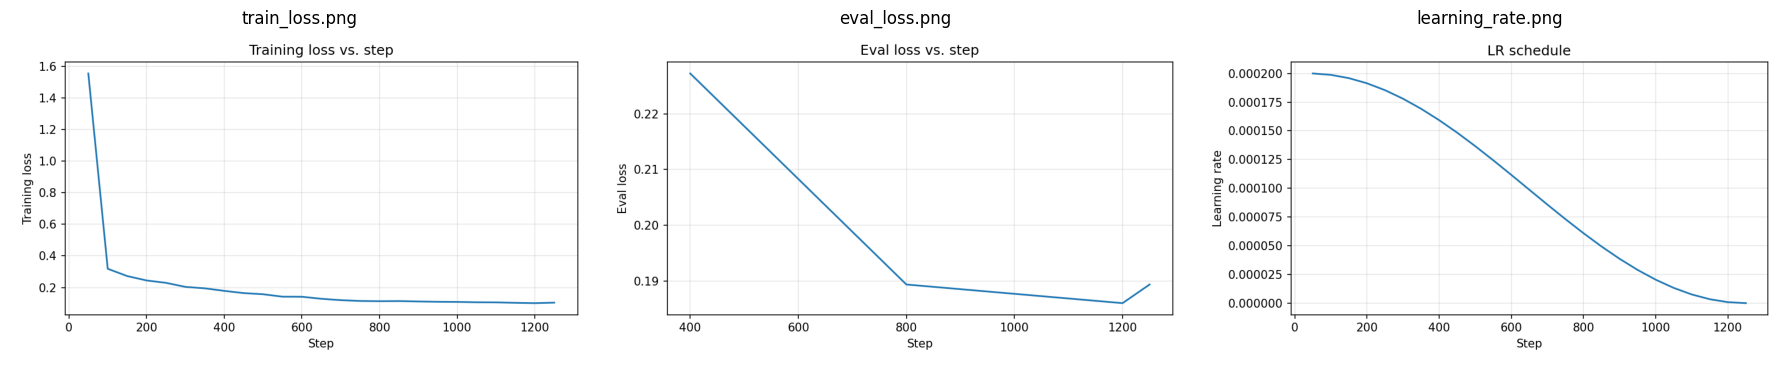

In [32]:
# Visualize the plots
diag_dir = os.path.join("runs", "llama_pairwise_lora", "diagnostics")
files = ["train_loss.png", "eval_loss.png", "learning_rate.png"]
paths = [os.path.join(diag_dir, f) for f in files if os.path.exists(os.path.join(diag_dir, f))]

if not paths:
    print("No images found.")
else:
    n = len(paths)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 4))
    if n == 1:
        axes = [axes]  # normalize to list
    for ax, p in zip(axes, paths):
        ax.imshow(mpimg.imread(p))
        ax.set_title(os.path.basename(p))
        ax.axis("off")
    plt.tight_layout()
    plt.show()



### TensorBoard - Training and Evaluation Results 
<img src="./sup_imgs/TensorBoard_results.png" width="1500" style="vertical-align: middle;"/>

### Training Summary

- **Training convergence:** The loss curves show a healthy training trajectory.  
  - **Training loss** decreases rapidly at the start and then stabilizes around **0.21**.  
  - **Evaluation loss** follows a similar pattern, reaching its minimum near **step 800**, with a small uptick afterwards, indicating the best checkpoint is likely **`checkpoint-800`**.

- **Metrics:**
  - Final **train loss ≈ 0.210**
  - Final **eval loss ≈ 0.189**
  - **Perplexity ≈ 1.21** tight fit, no sign of overfitting.

- **Learning rate schedule:** The cosine decay performed as expected. A smooth reduction toward zero as training progressed, aligning with the stable losses in the later steps.

- **Training performance:**  
  Throughput remained consistent at ~**0.099 steps/s**, with an effective batch size of **16** (gradient accumulation) over **10,000 train** and **1,250 validation** samples.

**Interpretation:**  
The model converged cleanly and efficiently under LoRA fine-tuning.  
Validation loss improvement plateaued around step 800, so that checkpoint should be selected for downstream evaluation and inference.  
The slight late-stage rise in eval loss matches the decayed learning rate, expected behavior indicating convergence rather than instability.


In [33]:
# Save adapter + tokenizer
adapter_dir = "runs/llama_pairwise_lora/adapter"
trainer.save_model(adapter_dir)
tok.save_pretrained("runs/llama_pairwise_lora/tokenizer")
print("Saved LoRA adapter ->", adapter_dir)

Saved LoRA adapter -> runs/llama_pairwise_lora/adapter


We saved only the trainable LoRA parameters (the low-rank adapters), small, efficient deltas that can later be re-attached to the frozen base model.

### Saving the LoRA Adapter and Tokenizer

At this stage, we save only the **LoRA adapter parameters**, not the entire base model. These adapter weights contain the **low-rank matrices (A and B)** learned during fine-tuning, which represent the task-specific updates added to the frozen **LLaMA-3.2-3B** base model.

Because LoRA stores only these lightweight deltas (usually a few MB), the base model remains unchanged and can be reused for other tasks. Later, during inference or evaluation, these adapters will be **loaded back onto the base model** to recreate the fine-tuned version of the LLM.

The **tokenizer** is also saved to preserve the same tokenization rules used during training, ensuring consistency in all future inference runs.

----